# MultiDoppler retrieval from 2/3 radars

- Reading radar files for specific cases, when hailfall occurred:
    - 2017-11-15 21h40 (SR/CTH and SR/CTH/XPOL)
    - 2017-03-14 18h30 and 20h (SR/CTH)
- Executing [MultiDop](https://github.com/nasa/MultiDop) workflow
- Plotting wind and reflectivity fields derived

Based on [MultiDop example workflow](https://github.com/nasa/MultiDop/blob/master/examples/MultiDop_Sample_Workflow.ipynb).

---
Considering HDF5 compatibility problem:
**RUN THIS LINE BEFORE OPEN JUPYTER!**

```
export HDF5_DISABLE_VERSION_CHECK=1
```
---

## Loading necessary packages

In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import cm
from copy import deepcopy
import multidop
import pyart
import read_brazil_radar as rbr
import tempfile
import os
import time
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



## Defining necessary functions

### `read_dealise_radar`
Using the name of the radar file (*filename*):

- Read radar file with `pyart` or `read_brazil_radar` script
- Correct dealising problems with `pyart`
- Add a *missing_value* (and *_FillValue* if not available) field inside reflectivity (*DT*) and velocity (*VT*) fields

In [2]:
def read_dealise_radar(filename, dbz_field='corrected_reflectivity',
                       vel_field='corrected_velocity'):
    #- Reading radar file
    try:
        radar = pyart.aux_io.read_gamic(filename)
    except AttributeError:
        radar = rbr.read_rainbow_hdf5(filename)
    
    #- Correct dealising
    cp = deepcopy(radar.fields[dbz_field]['data'])
    radar.add_field_like(dbz_field, 'DT', cp, replace_existing=True)
    gatefilter = pyart.correct.GateFilter(radar)
    gatefilter.exclude_masked(dbz_field)
    corr_vel = pyart.correct.dealias_region_based(radar, vel_field=vel_field,
                                                  keep_original=False, 
                                                  gatefilter=gatefilter,
                                                  centered=True)
    radar.add_field('VT', corr_vel, replace_existing=True)
    
    #- Correct missing_value and _FillValue fields
    try:
        radar.fields['DT']['missing_value'] = 1.0 * radar.fields['DT']['_FillValue']
        radar.fields['VT']['missing_value'] = 1.0 * radar.fields['VT']['_FillValue']
    except KeyError:
        radar.fields['DT']['_FillValue'] = radar.fields['DT']['data'].fill_value
        radar.fields['DT']['missing_value'] = 1.0 * radar.fields['DT']['_FillValue']
        radar.fields['VT']['_FillValue'] = radar.fields['VT']['data'].fill_value
        radar.fields['VT']['missing_value'] = 1.0 * radar.fields['VT']['_FillValue']
        
    return radar

### `grid_radar`
Using radar data (*radar*):

- Create a gridded version (*grid*) with `pyart` 
- Add azimuth and elevation information as fields of *grid* using `multidop`

In [3]:
def grid_radar(radar, grid_shape=(20, 301, 301), xlim=(-150000, 150000),
               ylim=(-150000, 150000), zlim=(1000, 20000),
               fields=['DT', 'VT'], origin=None):
    bt = time.time()
    radar_list = [radar]
    if origin is None:
        origin = (radar.latitude['data'][0],
                  radar.longitude['data'][0])
    grid = pyart.map.grid_from_radars(
        radar_list, grid_shape=grid_shape,
        grid_limits=(zlim, ylim, xlim),
        grid_origin=origin, fields=fields,
        gridding_algo='map_gates_to_grid', grid_origin_alt=0.0)
    print(time.time()-bt, 'seconds to grid radar')
    grid = multidop.angles.add_azimuth_as_field(grid)
    grid = multidop.angles.add_elevation_as_field(grid)
    return grid

### `plot_gridded_radar`
Using gridded radar data (*radar*), plot reflectivity and velocity fields before and after dealising using `matplotlib.pyplot`.

In [4]:
def plot_gridded_radar(radar, name_radar, name_base, 
                       xlim=[-200, 10], ylim=[-10, 200]):
    fig = plt.figure(figsize=(6, 5))
    fig.set_facecolor('w')
    DZcomp = np.amax(radar.fields['DT']['data'], axis=0)
    x, y = np.meshgrid(0.001*radar.x['data'], 0.001*radar.y['data'])
    cs = plt.pcolormesh(0.001*radar.x['data'], 0.001*radar.y['data'],
                        DZcomp, vmin=0, vmax=75, cmap='pyart_NWSRef')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.colorbar(cs, label='Reflectivity (dBZ)')
    plt.title('Max Reflectivity (filled) of ' + name_radar)
    plt.xlabel('Distance east of ' + name_base + '  (km)')
    plt.ylabel('Distance north of ' + name_base + '  (km)')
    plt.show()

### calc_plot_wind_dbz
Using gridded multi-doppler processed data (*grid*):

- Select wind data and calculate grids and wind medians
- Plot horizontal and vertical views
    - In a specific height (*index*)
    - In a specific longitudinal cross-section (*lon_index*)

In [5]:
def calc_plot_wind_dbz(grid, lon_index, name_base, name_multi,
                       index=2, thin=2, 
                       xlim_hv=(-150, -120), ylim_hv=(50, 85),
                       xlim_vv=(50, 85), ylim_vv=(2, 20)):
    # Selecting data
    U = grid.fields['eastward_wind']['data']
    V = grid.fields['northward_wind']['data']
    W = grid.fields['upward_air_velocity']['data']
    Z = grid.fields['reflectivity']['data']

    # Grids
    x, y = np.meshgrid(0.001*grid.x['data'], 0.001*grid.y['data'])
    y_cs, z_cs = np.meshgrid(0.001*grid.y['data'], 0.001*grid.z['data'])

    # Wind medians - necessary?
    Um = np.ma.median(U[index])
    Vm = np.ma.median(V[index])
    Wm = np.ma.median([W[i][:,lon_index] for i in range(0,20)])
    
    # HORIZONTAL VIEW

    # Main figure
    fig = plt.figure(figsize=(10, 8))
    fig.set_facecolor('w')
    ax = fig.add_subplot(111)

    # Reflectivity (shaded)
    cs = ax.pcolormesh(0.001*grid.x['data'], 0.001*grid.y['data'],
                       Z[index], vmin=0, vmax=65, cmap=cm.GMT_wysiwyg)
    plt.colorbar(cs, label='Reflectivity (dBZ)', ax=ax)
    
    # Vertical wind (contour)
    cl = plt.contour(x, y, W[index], levels=range(-20, 20), colors=['k'], linewidths=1)
    plt.clabel(cl, inline=1, fontsize=10, fmt='%1.0f', inline_spacing=0.01)
    
    # Wind arrows
    winds = ax.quiver(x[::thin, ::thin], y[::thin, ::thin], U[index][::thin, ::thin],
                     V[index][::thin, ::thin], scale=5, units='xy',
                     color='brown', label='Winds (m/s)')
    ax.quiverkey(winds, 0.8, 0.08, 5, '5 m/s', coordinates='figure')
    
    # General aspects
    ax.set_xlim(xlim_hv)
    ax.set_ylim(ylim_hv)
    ax.set_xlabel('Distance East of ' + name_base + ' (km)')
    ax.set_ylabel('Distance North of ' + name_base + ' (km)')
    ax.set_title(name_multi + ' U & V, W (contours, m/s),' +
                 ' & dBZ @ ' + str(index+1) + ' km MSL')
    
    plt.show()
    
    # VERTICAL VIEW
    
    # Main figure
    fig = plt.figure(figsize=(10, 8))
    fig.set_facecolor('w')
    ax = fig.add_subplot(111)

    # Reflectivity (shaded)
    cs = ax.pcolormesh(0.001*grid.y['data'], 0.001*grid.z['data'],
                       [Z[i][:,lon_index] for i in range(0,20)], vmin=0, vmax=65,
                       cmap=cm.GMT_wysiwyg)
    plt.colorbar(cs, label='Reflectivity (dBZ)', ax=ax)

    # Vertical wind (contour)
    cl = plt.contour(y_cs, z_cs, [W[i][:,lon_index] for i in range(0,20)], 
                     levels=range(-20, 20), colors=['k'], linewidths=1)
    plt.clabel(cl, inline=1, fontsize=10, fmt='%1.0f', inline_spacing=0.01)

    # Wind barbs
    wind = ax.quiver(y_cs, z_cs, [V[i][:,lon_index] for i in range(0,20)],
                     [W[i][:,lon_index] for i in range(0,20)], scale=5, units='xy',
                     color='brown', label='Winds (m/s)')
    ax.quiverkey(wind, 0.8, 0.08, 5, '5 m/s', coordinates='figure')

    ax.set_xlim(xlim_vv)
    ax.set_ylim(ylim_vv)
    ax.set_xlabel('Distance North of ' + name_base + ' (km)')
    ax.set_ylabel('Distance above ' + name_base + ' (km)')
    ax.set_title(name_multi + ' V & W, W (contours, m/s),' +
                 ' & dBZ @ '+str(x[0,lon_index])+' km East of ' + name_base)
    
    plt.show()

## Case: 2017-11-15

### Custom variables

In [7]:
filenames = open("filenames_20171115.txt").read().split('\n')
grid_xlim, grid_ylim = (-200000.0, 10000.0), (-10000.0, 200000.0)
grid_shape = (20, 211, 211)
grid_spacing = 1000.0

### Reading data

In [8]:
radar_1 = read_dealise_radar(filenames[0]) #- SR
radar_2 = read_dealise_radar(filenames[1], vel_field='velocity') #- CTH
radar_3 = read_dealise_radar(filenames[2], vel_field='velocity') #- XPOL

/rhome/clopes/anaconda3/lib/python3.5/site-packages/pyart/correct/region_dealias.py:292: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)
/rhome/clopes/anaconda3/lib/python3.5/site-packages/pyart/correct/region_dealias.py:292: UserWarning: Velocities outside of the Nyquist interval found in sweep 1.
  warnings.warn(msg, UserWarning)
/rhome/clopes/anaconda3/lib/python3.5/site-packages/pyart/correct/region_dealias.py:292: UserWarning: Velocities outside of the Nyquist interval found in sweep 2.
  warnings.warn(msg, UserWarning)
/rhome/clopes/anaconda3/lib/python3.5/site-packages/pyart/correct/region_dealias.py:292: UserWarning: Velocities outside of the Nyquist interval found in sweep 3.
  warnings.warn(msg, UserWarning)
/rhome/clopes/anaconda3/lib/python3.5/site-packages/pyart/correct/region_dealias.py:292: UserWarning: Velocities outside of the Nyquist interval found in sweep 4.
  warnings.warn(msg, UserWarning)
/rhome/clopes/a

TypeError: strptime() argument 1 must be str, not bytes

### Gridding based on radar_2 (CTH)

In [8]:
grid_1 = grid_radar(radar_1, origin=(radar_2.latitude['data'][0], radar_2.longitude['data'][0]),
                    xlim=grid_xlim, ylim=grid_ylim, grid_shape=grid_shape)
grid_2 = grid_radar(radar_2, origin=(radar_2.latitude['data'][0], radar_2.longitude['data'][0]),
                    xlim=grid_xlim, ylim=grid_ylim, grid_shape=grid_shape)
grid_3 = grid_radar(radar_3, origin=(radar_2.latitude['data'][0], radar_2.longitude['data'][0]),
                    xlim=grid_xlim, ylim=grid_ylim, grid_shape=grid_shape)

/home/camila/anaconda2/lib/python2.7/site-packages/pyart/core/transforms.py:632: RuntimeWarning: invalid value encountered in sqrt
  rho = np.sqrt(x*x + y*y)


2.01844000816 seconds to grid radar
4.83279681206 seconds to grid radar
2.75371289253 seconds to grid radar


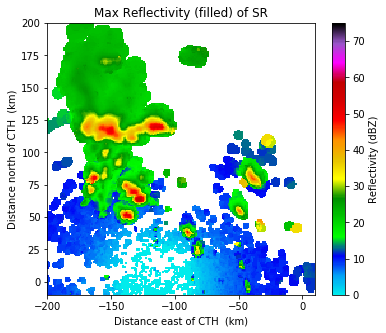

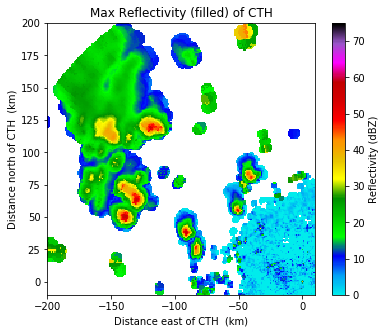

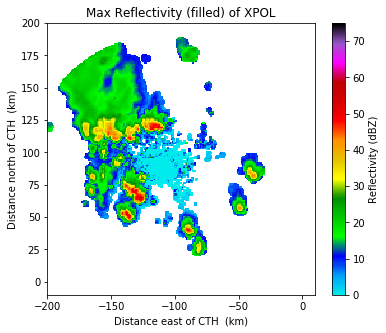

In [9]:
plot_gridded_radar(grid_1, 'SR', 'CTH')
plot_gridded_radar(grid_2, 'CTH', 'CTH')
plot_gridded_radar(grid_3, 'XPOL', 'CTH')

## Writing data to file

In [10]:
pyart.io.write_grid('radar_1.nc', grid_1)
pyart.io.write_grid('radar_2.nc', grid_2)
pyart.io.write_grid('radar_3.nc', grid_3)

## Loading parameters and updating

#### 2 Radars (SR, CTH)

In [11]:
from multidop_parameters import params

localfile = tempfile.NamedTemporaryFile()
params['writeout'] = localfile.name

In [12]:
params['x'] = [grid_xlim[0], grid_spacing, grid_shape[1]]
params['y'] = [grid_ylim[0], grid_spacing, grid_shape[1]]
params['z'][1] = grid_spacing
params['grid'] = [grid_1.origin_longitude['data'][0], grid_1.origin_latitude['data'][0], 0.0]
params['radar_names'] = ['SR', 'CTH']

pf = multidop.parameters.ParamFile(params, 'case_20171115_2rad.dda')
pf = multidop.parameters.CalcParamFile(params, 'calculations.dda')

#### Executing DDA engine
Text output will display with delay

In [13]:
bt = time.time()
multidop.execute.do_analysis('case_20171115_2rad.dda', cmd_path='src/DDA')
print((time.time()-bt)/60.0, 'minutes to process')

DDA 0.9.0
./DDA: reading calculation parameters from calculations.dda.
Changing working directory to ./
x: -200000.000000 to 10000.000000 in 210 steps of 1000.000000
y: -10000.000000 to 200000.000000 in 210 steps of 1000.000000
z: 1000.000000 to 20000.000000 in 19 steps of 1000.000000
z_min=1000, cutoff=0
UT=0, VT=0
Anelastic mass cons
First-order smoothness constraint
Minimum beam crossing angle = 20 degrees
Py-ART grids for analyis and all radars must match to within (dx, dy, dz) < (10 10 10) meters.
Reading Py-ART fileradar_1.nc
radar_2.nc

Radar positions:  (-114194,-581.287) (0.12019,-0.0946679)
Computing coverage: 84457 verification points out of 890420 total points.
radar0 100226 obs. radar1 158397 obs. 258623 total obs.
Analyzed obs = 258623. Mean Vr = 6.99364
C1b=1 C2b=10 C3b=0 C4b=1 C5b=0 C6b=0 C7b=1 C8b=0
C2a=10 C3a=0 C4a=1 C5a=0 C6a=0 C7a=1 C8a=0
Weighting all obs equally!
GradCheck: rchek = 1e+10. fx1 = 104699
GradCheck: gxnn = 11884.3
GradCheck: j = 1. fx2 = 4.12e+20. fff

#### Writing final grid to a file
Baseline output is not CF or Py-ART compliant. This function fixes that.

The final grid will have all wind solutions outside the coverage region masked.

In [14]:
# fname = 'case_20171115_cf_2rad.nc'
final_grid = multidop.grid_io.make_new_grid([grid_1, grid_2], localfile.name)
# final_grid.write(fname)
grid_2rad = final_grid
localfile.close()

#### 3 Radars (SR, CTH, XPOL)

In [15]:
from multidop_parameters import params

localfile = tempfile.NamedTemporaryFile()
params['writeout'] = localfile.name

In [16]:
params['x'] = [grid_xlim[0], grid_spacing, grid_shape[1]]
params['y'] = [grid_ylim[0], grid_spacing, grid_shape[1]]
params['z'][1] = grid_spacing
params['grid'] = [grid_1.origin_longitude['data'][0], grid_1.origin_latitude['data'][0], 0.0]
params['files'].append('radar_3.nc')
params['radar_names'] = ['SR', 'CTH', 'XPOL']

pf = multidop.parameters.ParamFile(params, 'case_20171115_3rad.dda')
pf = multidop.parameters.CalcParamFile(params, 'calculations.dda')

#### Executing DDA engine
Text output will display with delay

In [17]:
bt = time.time()
multidop.execute.do_analysis('case_20171115_3rad.dda', cmd_path='src/DDA')
print((time.time()-bt)/60.0, 'minutes to process')

DDA 0.9.0
./DDA: reading calculation parameters from calculations.dda.
Changing working directory to ./
x: -200000.000000 to 10000.000000 in 210 steps of 1000.000000
y: -10000.000000 to 200000.000000 in 210 steps of 1000.000000
z: 1000.000000 to 20000.000000 in 19 steps of 1000.000000
z_min=1000, cutoff=0
UT=0, VT=0
Anelastic mass cons
First-order smoothness constraint
Minimum beam crossing angle = 20 degrees
Py-ART grids for analyis and all radars must match to within (dx, dy, dz) < (10 10 10) meters.
Reading Py-ART fileradar_1.nc
radar_2.nc
radar_3.nc

Radar positions:  (-114194,-581.287) (0.12019,-0.0946679) (-110974,87023)
Computing coverage: 94500 verification points out of 890420 total points.
radar0 100226 obs. radar1 158397 obs. radar2 74887 obs. 333510 total obs.
Analyzed obs = 333510. Mean Vr = 6.6886
C1b=1 C2b=10 C3b=0 C4b=1 C5b=0 C6b=0 C7b=1 C8b=0
C2a=10 C3a=0 C4a=1 C5a=0 C6a=0 C7a=1 C8a=0
Weighting all obs equally!
GradCheck: rchek = 1e+10. fx1 = 143872
GradCheck: gxnn = 1

#### Writing final grid to a file
Baseline output is not CF or Py-ART compliant. This function fixes that.

The final grid will have all wind solutions outside the coverage region masked.

In [18]:
# fname = 'case_20171115_cf_3rad.nc'
final_grid = multidop.grid_io.make_new_grid([grid_1, grid_2, grid_3], localfile.name)
# final_grid.write(fname)
grid_3rad = final_grid
localfile.close()

### Reading/plotting results

In [19]:
# grid_2rad = pyart.io.read_grid('case_20171115_cf_2rad.nc')
# grid_3rad = pyart.io.read_grid('case_20171115_cf_3rad.nc')
print(grid_2rad.fields.keys(), grid_3rad.fields.keys())

['eastward_wind', 'upward_air_velocity', 'northward_wind', 'reflectivity'] ['eastward_wind', 'upward_air_velocity', 'northward_wind', 'reflectivity']


#### Quick first look

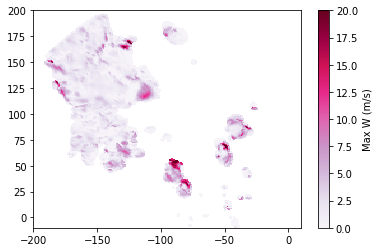

In [20]:
cs = plt.pcolormesh(0.001*grid_3rad.x['data'], 0.001*grid_3rad.y['data'],
                    np.amax(grid_3rad.fields['upward_air_velocity']['data'], axis=0),
                    vmin=0, vmax=20, cmap='PuRd')
plt.colorbar(cs, label='Max W (m/s)')

Text(0,0.5,'Distance north of CTH (km)')

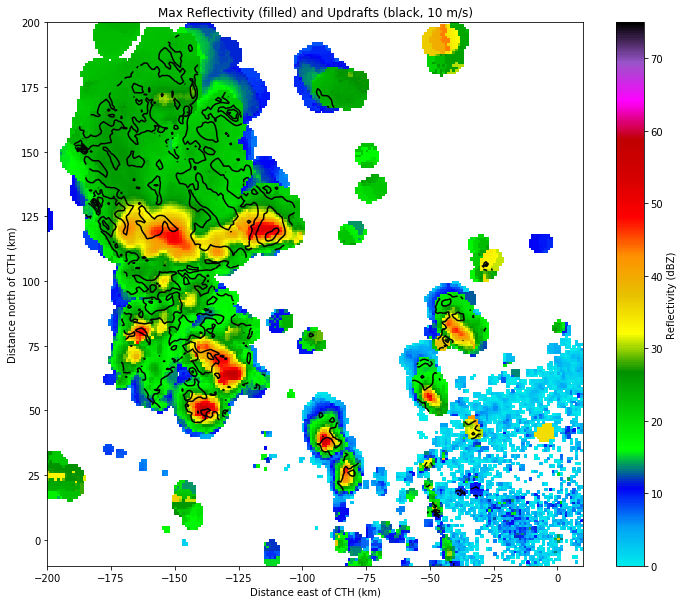

In [21]:
fig = plt.figure(figsize=(12, 10))
fig.set_facecolor('w')
DZcomp = np.amax(grid_2rad.fields['reflectivity']['data'], axis=0)
x, y = np.meshgrid(0.001*grid_2rad.x['data'], 0.001*grid_2rad.y['data'])
cs = plt.pcolormesh(0.001*grid_2rad.x['data'], 0.001*grid_2rad.y['data'],
                    DZcomp, vmin=0, vmax=75, cmap='pyart_NWSRef')
Wcomp = np.amax(grid_2rad.fields['upward_air_velocity']['data'], axis=0)
plt.contour(x, y, Wcomp, levels=[1, 6, 11, 16, 21], colors=['k', 'k', 'k'])
plt.xlim(-200, 10)
plt.ylim(-10, 200)
plt.colorbar(cs, label='Reflectivity (dBZ)')
plt.title('Max Reflectivity (filled) and Updrafts (black, 10 m/s)')
plt.xlabel('Distance east of CTH (km)')
plt.ylabel('Distance north of CTH (km)')

#### Focusing on selected system

##### 2 radars (SR, CTH)

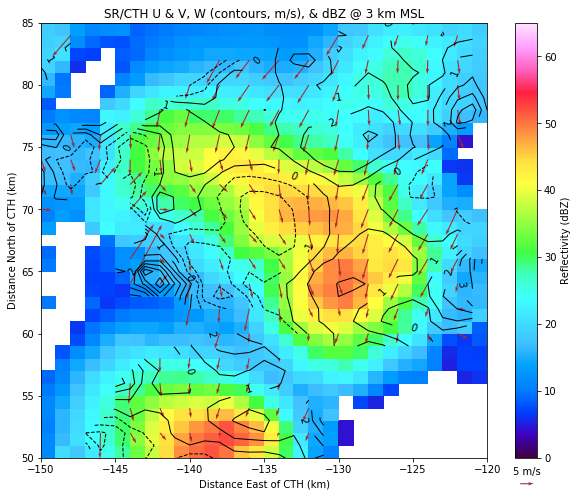

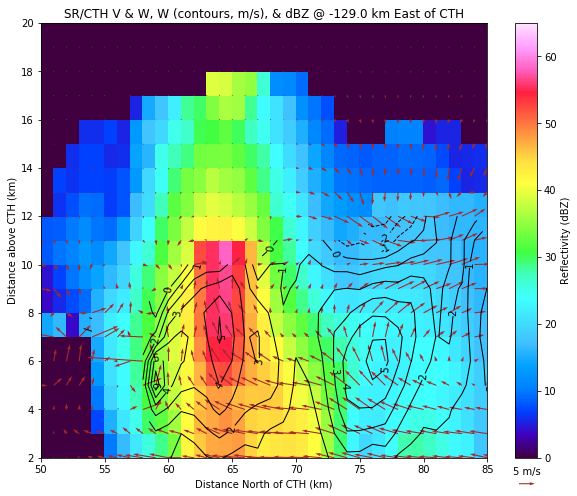

In [22]:
calc_plot_wind_dbz(grid_2rad, lon_index=71, name_base='CTH',
                   name_multi='SR/CTH')

##### 3 radars (SR, CTH, XPOL)

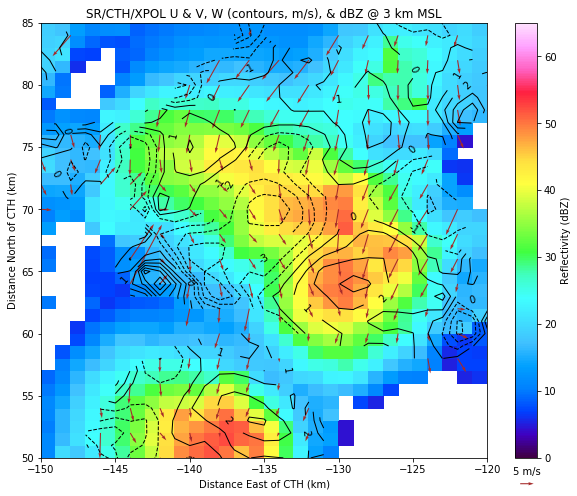

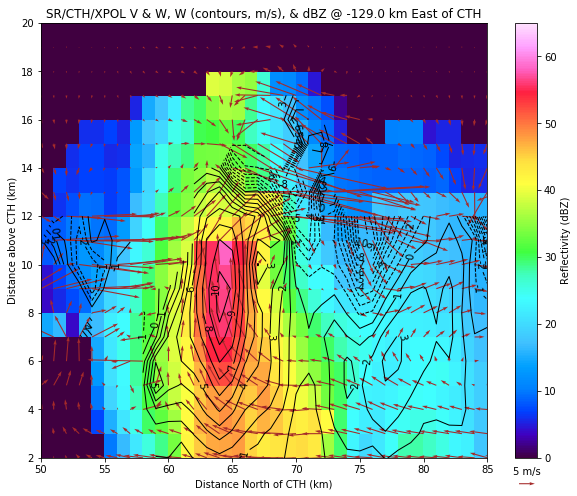

In [23]:
calc_plot_wind_dbz(grid_3rad, lon_index=71, name_base='CTH',
                   name_multi='SR/CTH/XPOL')

In [ ]:
pyart_grid = grid_3rad

In [ ]:
# Selecting data
U = pyart_grid.fields['eastward_wind']['data']
V = pyart_grid.fields['northward_wind']['data']
W = pyart_grid.fields['upward_air_velocity']['data']
Z = pyart_grid.fields['reflectivity']['data']

# Grid
x, y = np.meshgrid(0.001*pyart_grid.x['data'], 0.001*pyart_grid.y['data'])

# General setup
ind = 2 # level
thin = 2 # wind grid

# Wind medians - necessary?
Um = np.ma.median(U[ind])
Vm = np.ma.median(V[ind])

### Horizontal view

#### 3 radars

In [ ]:
# Main figure
fig = plt.figure(figsize=(10, 8))
fig.set_facecolor('w')
ax = fig.add_subplot(111)

# Reflectivity (shaded)
cs = ax.pcolormesh(0.001*pyart_grid.x['data'], 0.001*pyart_grid.y['data'],
                   Z[ind], vmin=0, vmax=65, cmap=cm.GMT_wysiwyg)
plt.colorbar(cs, label='Reflectivity (dBZ)', ax=ax)

# Vertical wind (contour)
cl = plt.contour(x, y, W[ind], levels=range(-20, 20), colors=['k'], linewidths=1)
plt.clabel(cl, inline=1, fontsize=10, fmt='%1.0f', inline_spacing=0.01)

# Wind arrows
wind = ax.quiver(x[::thin, ::thin], y[::thin, ::thin], U[ind][::thin, ::thin],
                 V[ind][::thin, ::thin], scale=5, units='xy',
                 color='brown', label='Winds (m/s)')
ax.quiverkey(wind, 0.8, 0.08, 5, '5 m/s', coordinates='figure')

# General aspects
ax.set_xlim(-150, -120)
ax.set_ylim(50, 85)
ax.set_xlabel('Distance East of CTH (km)')
ax.set_ylabel('Distance North of CTH (km)')
ax.set_title('CTH/SR/XPOL U & V, W (contours, m/s),' +
             ' & dBZ @ '+str(ind+1)+' km MSL')

#### 2 radars

In [ ]:
# Main figure
fig = plt.figure(figsize=(10, 8))
fig.set_facecolor('w')
ax = fig.add_subplot(111)

# Reflectivity (shaded)
cs = ax.pcolormesh(0.001*pyart_grid.x['data'], 0.001*pyart_grid.y['data'],
                   Z[ind], vmin=0, vmax=65, cmap=cm.GMT_wysiwyg)
plt.colorbar(cs, label='Reflectivity (dBZ)', ax=ax)

# Vertical wind (contour)
cl = plt.contour(x, y, W[ind], levels=range(-20, 20), colors=['k'], linewidths=1)
plt.clabel(cl, inline=1, fontsize=10, fmt='%1.0f', inline_spacing=0.01)

# Wind arrows
wind = ax.quiver(x[::thin, ::thin], y[::thin, ::thin], U[ind][::thin, ::thin],
                 V[ind][::thin, ::thin], scale=5, units='xy',
                 color='brown', label='Winds (m/s)')
ax.quiverkey(wind, 0.8, 0.08, 5, '5 m/s', coordinates='figure')

# General aspects
ax.set_xlim(-150, -120)
ax.set_ylim(50, 85)
ax.set_xlabel('Distance East of CTH (km)')
ax.set_ylabel('Distance North of CTH (km)')
ax.set_title('CTH/SR U & V, W (contours, m/s),' +
             ' & dBZ @ '+str(ind+1)+' km MSL')

### Vertical view

In [ ]:
# Grid
y_cs, z_cs = np.meshgrid(0.001*pyart_grid.y['data'], 0.001*pyart_grid.z['data'])

# Wind medians - necessary?
Wm = np.ma.median([W[i][:,71] for i in range(0,20)])

#### 3 radars

In [ ]:
# Main figure
fig = plt.figure(figsize=(10, 8))
fig.set_facecolor('w')
ax = fig.add_subplot(111)

# Reflectivity (shaded)
cs = ax.pcolormesh(0.001*pyart_grid.y['data'], 0.001*pyart_grid.z['data'],
                   [Z[i][:,71] for i in range(0,20)], vmin=0, vmax=65,
                   cmap=cm.GMT_wysiwyg)
plt.colorbar(cs, label='Reflectivity (dBZ)', ax=ax)

# Vertical wind (contour)
cl = plt.contour(y_cs, z_cs, [W[i][:,71] for i in range(0,20)], 
                 levels=range(-20, 20), colors=['k'], linewidths=1)
plt.clabel(cl, inline=1, fontsize=10, fmt='%1.0f', inline_spacing=0.01)

# Wind barbs
wind = ax.quiver(y_cs, z_cs, [V[i][:,71] for i in range(0,20)],
                 [W[i][:,71] for i in range(0,20)], scale=5, units='xy', 
                 color='brown', label='Winds (m/s)')
ax.quiverkey(wind, 0.8, 0.08, 5, '5 m/s', coordinates='figure')

ax.set_xlim(50, 85)
ax.set_ylim(2, 20)
ax.set_xlabel('Distance North of CTH (km)')
ax.set_ylabel('Distance above CTH (km)')
ax.set_title('CTH/SR/XPOL V & W, W (contours, m/s),' +
             ' & dBZ @ '+str(x[0,71])+' km East of CTH')

#### 2 radars

In [ ]:
# Main figure
fig = plt.figure(figsize=(10, 8))
fig.set_facecolor('w')
ax = fig.add_subplot(111)

# Reflectivity (shaded)
cs = ax.pcolormesh(0.001*pyart_grid.y['data'], 0.001*pyart_grid.z['data'],
                   [Z[i][:,71] for i in range(0,20)], vmin=0, vmax=65,
                   cmap=cm.GMT_wysiwyg)
plt.colorbar(cs, label='Reflectivity (dBZ)', ax=ax)

# Vertical wind (contour)
cl = plt.contour(y_cs, z_cs, [W[i][:,71] for i in range(0,20)], 
                 levels=range(-20, 20), colors=['k'], linewidths=1)
plt.clabel(cl, inline=1, fontsize=10, fmt='%1.0f', inline_spacing=0.01)

# Wind barbs
wind = ax.quiver(y_cs, z_cs, [V[i][:,71] for i in range(0,20)],
                 [W[i][:,71] for i in range(0,20)], scale=5, units='xy', 
                 color='brown', label='Winds (m/s)')
ax.quiverkey(wind, 0.8, 0.08, 5, '5 m/s', coordinates='figure')

ax.set_xlim(50, 85)
ax.set_ylim(2, 20)
ax.set_xlabel('Distance North of CTH (km)')
ax.set_ylabel('Distance above CTH (km)')
ax.set_title('CTH/SR V & W, W (contours, m/s),' +
             ' & dBZ @ '+str(x[0,71])+' km East of CTH')